# Congressional voting data

Identify party allegiance of members of the US national congress based on their voting behaviour.

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from math import sqrt
from math import log2
%matplotlib inline

# General sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler,QuantileTransformer,normalize
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.model_selection import cross_val_score

# Models
from sklearn.ensemble import RandomForestClassifier as RFC

from IPython.display import display

In [54]:
# Custom functions
import pathlib
import os
import sys

module_path = pathlib.Path(os.getcwd()).parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))
print(sys.path)

from common.dataset_grabber import get_data_path
import functions

['/Users/peterholzner/Code/ML_2020/Ex1/voting', '/Users/peterholzner/.vscode/extensions/ms-python.python-2020.10.332292344/pythonFiles', '/Users/peterholzner/.vscode/extensions/ms-python.python-2020.10.332292344/pythonFiles/lib/python', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python38.zip', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/lib-dynload', '', '/Users/peterholzner/.local/share/virtualenvs/ML_2020-8PJoZtYC/lib/python3.8/site-packages', '/Users/peterholzner/.local/share/virtualenvs/ML_2020-8PJoZtYC/lib/python3.8/site-packages/IPython/extensions', '/Users/peterholzner/.ipython', '/Users/peterholzner/Code/ML_2020/Ex1']


In [29]:
datapath = get_data_path("Congressional_Voting", "CongressionalVotingID.shuf.train.csv")
display(datapath)

PosixPath('/Users/peterholzner/Code/ML_2020/Ex1/Datasets/Congressional_Voting/CongressionalVotingID.shuf.train.csv')

In [36]:
def preprocess_voting_rf(df:pd.DataFrame):
    try: 
        df.rename(columns={"class": "Class"})
    except:
        print("Did not find col \"class\"!")

    num_samples, num_cols = df.shape
    num_feats = num_cols -2
    num_samples, num_cols, num_feats

    target = "Class"
    feats = [x for x in df.columns if x not in [target, "ID"]]

    df.replace({"y": 1, "n": -1, "unknown": 0}, inplace=True)

    return df, (num_samples, num_cols, num_feats), (target, feats)

In [37]:
print("Before preprocess:")
df = pd.read_csv(datapath).rename(columns={"class": "Class"})
display(df.head())
print("-"*50)
print("After preprocess:")
df, (num_samples, num_cols, num_feats), (target, feats) = preprocess_voting_rf(df)
df.head()

Before preprocess:


,ID,Class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,134,republican,n,n,n,y,y,y,n,n,n,y,n,y,y,y,n,y
1,224,republican,n,n,n,y,y,n,n,n,n,n,n,y,y,y,n,y
2,32,democrat,y,y,y,n,n,n,y,y,y,n,y,n,n,n,y,unknown
3,171,democrat,y,n,y,n,n,n,unknown,y,y,unknown,n,n,n,n,y,unknown
4,333,democrat,y,n,y,n,n,n,y,y,y,n,y,n,n,n,y,unknown


--------------------------------------------------
After preprocess:


,ID,Class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,134,republican,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1,1,1,-1,1
1,224,republican,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,1,1,1,-1,1
2,32,democrat,1,1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,0
3,171,democrat,1,-1,1,-1,-1,-1,0,1,1,0,-1,-1,-1,-1,1,0
4,333,democrat,1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ID                                      218 non-null    int64 
 1   Class                                   218 non-null    object
 2   handicapped-infants                     218 non-null    int64 
 3   water-project-cost-sharing              218 non-null    int64 
 4   adoption-of-the-budget-resolution       218 non-null    int64 
 5   physician-fee-freeze                    218 non-null    int64 
 6   el-salvador-aid                         218 non-null    int64 
 7   religious-groups-in-schools             218 non-null    int64 
 8   anti-satellite-test-ban                 218 non-null    int64 
 9   aid-to-nicaraguan-contras               218 non-null    int64 
 10  mx-missile                              218 non-null    int64 
 11  immigr

Pretty sure I got all entries properly configured now :)

In [53]:
df.loc[:,"Class"]

0      republican
1      republican
2        democrat
3        democrat
4        democrat
          ...    
213      democrat
214    republican
215    republican
216    republican
217    republican
Name: Class, Length: 218, dtype: object

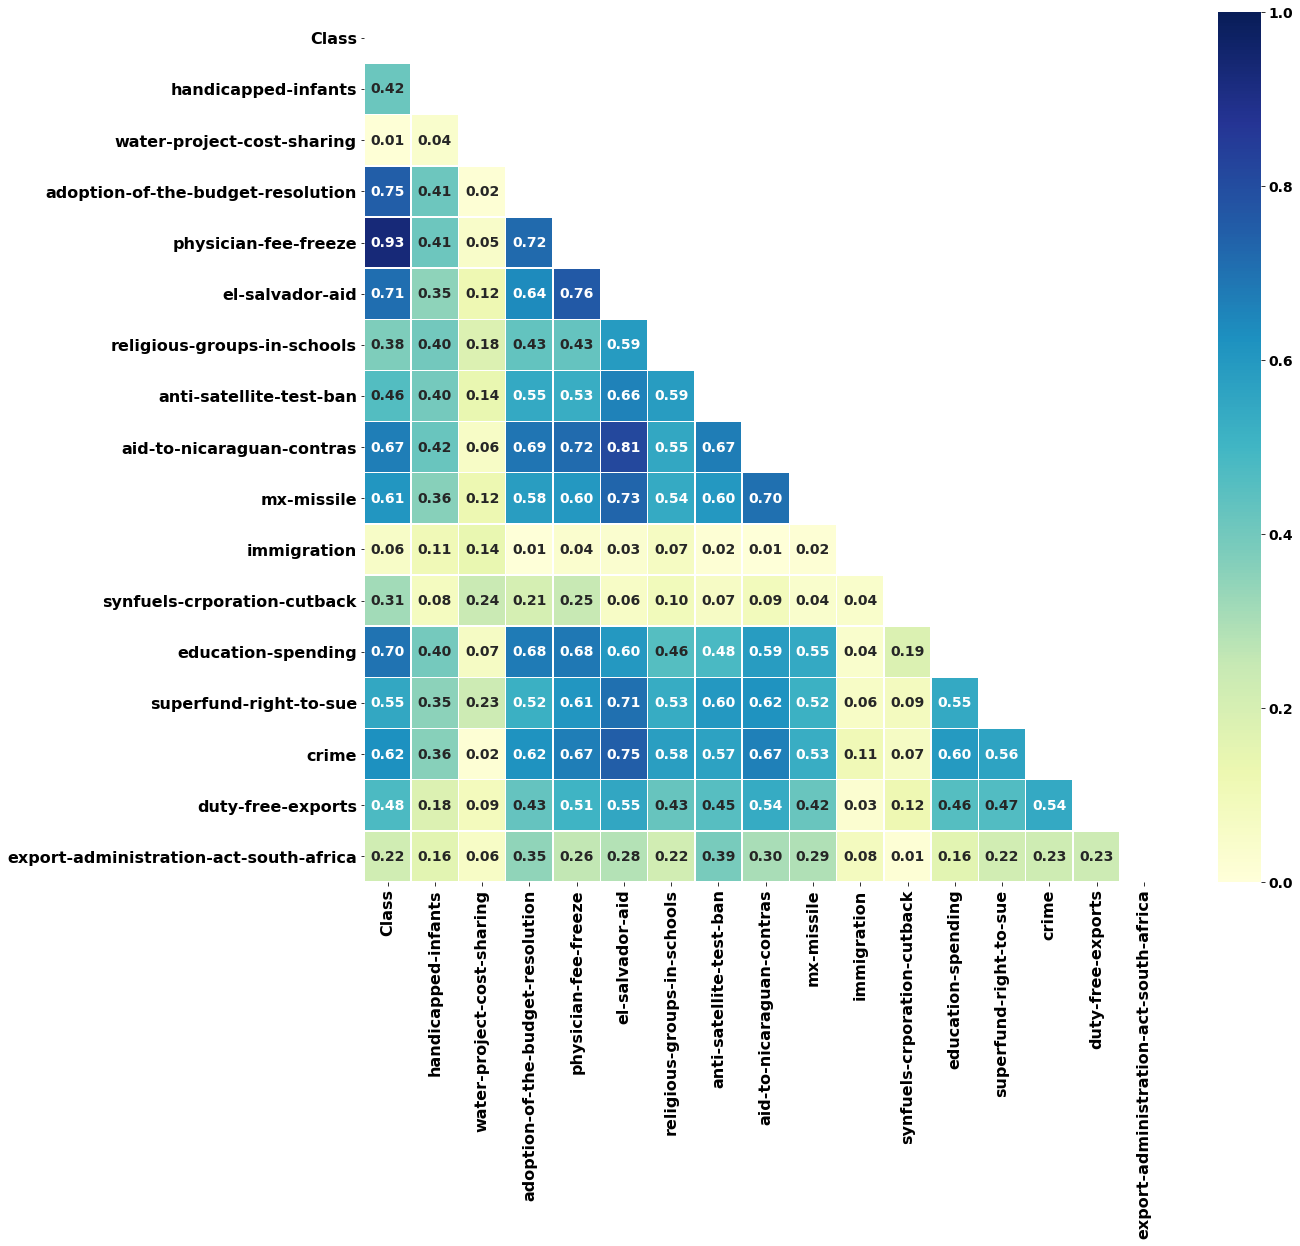

In [60]:
corr_to_feat = functions.plot_corr_heatmap(df[[target]+feats].replace({"republican":0, "democrat":1}), feat_to_ret="Class",ticksfont=16)

In [69]:
corr_to_feat

Class                                     1.000000
handicapped-infants                       0.415343
water-project-cost-sharing                0.010819
adoption-of-the-budget-resolution         0.747250
physician-fee-freeze                      0.930846
el-salvador-aid                           0.707494
religious-groups-in-schools               0.375694
anti-satellite-test-ban                   0.463905
aid-to-nicaraguan-contras                 0.669766
mx-missile                                0.607993
immigration                               0.057790
synfuels-crporation-cutback               0.314154
education-spending                        0.697679
superfund-right-to-sue                    0.550364
crime                                     0.624269
duty-free-exports                         0.477645
export-administration-act-south-africa    0.221004
Name: Class, dtype: float64

In [110]:
keep = list( filter(lambda x: x[0] > 0.3, list(zip(corr_to_feat, corr_to_feat.index))))
keep

[(1.0, 'Class'),
 (0.4153428103387732, 'handicapped-infants'),
 (0.7472498505670719, 'adoption-of-the-budget-resolution'),
 (0.9308464704181537, 'physician-fee-freeze'),
 (0.7074935131417974, 'el-salvador-aid'),
 (0.37569396722466464, 'religious-groups-in-schools'),
 (0.4639047949715226, 'anti-satellite-test-ban'),
 (0.6697661693052118, 'aid-to-nicaraguan-contras'),
 (0.6079929498910204, 'mx-missile'),
 (0.31415412974782797, 'synfuels-crporation-cutback'),
 (0.6976790125632946, 'education-spending'),
 (0.5503641705251486, 'superfund-right-to-sue'),
 (0.6242689752482551, 'crime'),
 (0.477644730404178, 'duty-free-exports')]

In [124]:
feats_keep = [x[1] for x in keep if x[1] != "Class"]
feats_keep

['handicapped-infants',
 'adoption-of-the-budget-resolution',
 'physician-fee-freeze',
 'el-salvador-aid',
 'religious-groups-in-schools',
 'anti-satellite-test-ban',
 'aid-to-nicaraguan-contras',
 'mx-missile',
 'synfuels-crporation-cutback',
 'education-spending',
 'superfund-right-to-sue',
 'crime',
 'duty-free-exports']

# Model

In [121]:
train, valid = train_test_split(df, test_size=0.3)
x, y = train[feats], train[target]
train.head()

,ID,Class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
155,62,republican,-1,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,1,-1,-1
195,315,republican,-1,1,-1,1,1,1,1,1,-1,-1,1,1,1,1,1,1
84,129,democrat,-1,0,1,-1,-1,1,-1,1,-1,1,1,-1,-1,-1,1,1
48,246,democrat,1,-1,1,-1,-1,-1,1,1,1,1,1,-1,-1,-1,1,1
43,263,democrat,1,-1,1,-1,-1,-1,1,1,1,1,-1,-1,0,-1,1,1


In [125]:
train, valid = train_test_split(df[[target]+feats_keep], test_size=0.3)
x, y = train[feats_keep], train[target]
train.head()

,Class,handicapped-infants,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports
157,republican,-1,-1,1,1,-1,-1,-1,-1,-1,1,1,1,-1
15,republican,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1
54,democrat,1,0,1,1,1,-1,-1,1,1,0,1,1,-1
9,democrat,-1,1,-1,-1,1,1,1,0,-1,-1,-1,-1,-1
170,democrat,1,1,-1,0,1,0,1,1,-1,-1,1,1,-1


In [126]:
display(x)
display(y)

,handicapped-infants,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports
157,-1,-1,1,1,-1,-1,-1,-1,-1,1,1,1,-1
15,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1
54,1,0,1,1,1,-1,-1,1,1,0,1,1,-1
9,-1,1,-1,-1,1,1,1,0,-1,-1,-1,-1,-1
170,1,1,-1,0,1,0,1,1,-1,-1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1,1,-1,-1,-1,1,1,1,1,-1,-1,-1,1
131,1,1,-1,-1,-1,1,1,0,1,-1,-1,-1,1
68,-1,1,-1,1,1,-1,-1,-1,1,1,1,1,-1
73,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1


157    republican
15     republican
54       democrat
9        democrat
170      democrat
          ...    
163      democrat
131      democrat
68       democrat
73     republican
66       democrat
Name: Class, Length: 152, dtype: object

In [127]:
scores={}

In [128]:
for n in [5, 10, 20, 100, 200, 500, 1000, 10000]:
    start = time.time()
    rf = RFC(n_jobs=-1, bootstrap=True, oob_score=True, n_estimators=n, verbose=0)
    scores[str(n)] = cross_val_score(rf, x, y, cv=5, n_jobs=-1)
    print(f"Runtime(n={n}): {time.time()-start:.3f}s")
print()
print(f"scores: {scores}")

Runtime(n=5): 0.104s
Runtime(n=10): 0.071s
Runtime(n=20): 0.091s
Runtime(n=100): 0.310s
Runtime(n=200): 0.579s
Runtime(n=500): 1.365s
Runtime(n=1000): 2.742s
Runtime(n=10000): 31.389s

scores: {'5': array([0.96774194, 0.90322581, 0.86666667, 0.93333333, 0.93333333]), '10': array([0.93548387, 0.93548387, 0.96666667, 0.96666667, 0.93333333]), '20': array([0.90322581, 0.93548387, 0.96666667, 0.96666667, 0.96666667]), '100': array([0.90322581, 0.93548387, 0.96666667, 0.96666667, 0.93333333]), '200': array([0.93548387, 0.93548387, 0.93333333, 0.96666667, 0.96666667]), '500': array([0.93548387, 0.93548387, 0.93333333, 0.93333333, 0.96666667]), '1000': array([0.93548387, 0.93548387, 0.93333333, 0.96666667, 0.96666667]), '10000': array([0.93548387, 0.93548387, 0.93333333, 0.93333333, 0.96666667])}


In [129]:
scores_mean = {}
for k, v in scores.items():
    scores_mean[k] = v.mean()
scores_mean

{'5': 0.9208602150537635,
 '10': 0.9475268817204301,
 '20': 0.9477419354838709,
 '100': 0.9410752688172043,
 '200': 0.9475268817204301,
 '500': 0.9408602150537634,
 '1000': 0.9475268817204301,
 '10000': 0.9408602150537634}

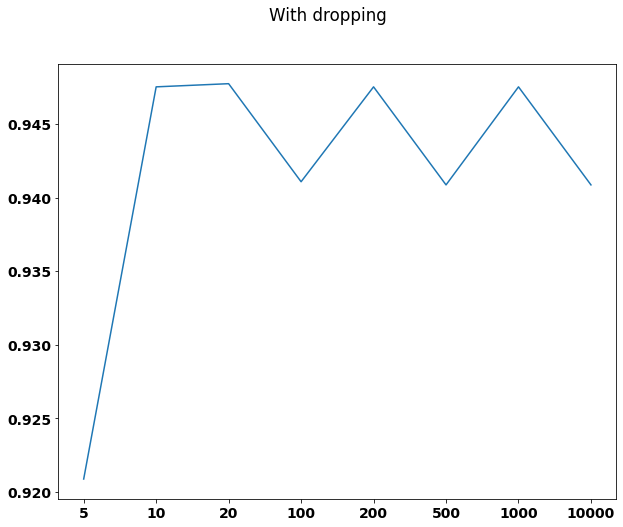

In [130]:
plt.figure(figsize=(10,8))
keys = scores_mean.keys()
values= scores_mean.values()
plt.plot(keys, values)
plt.suptitle("With dropping");

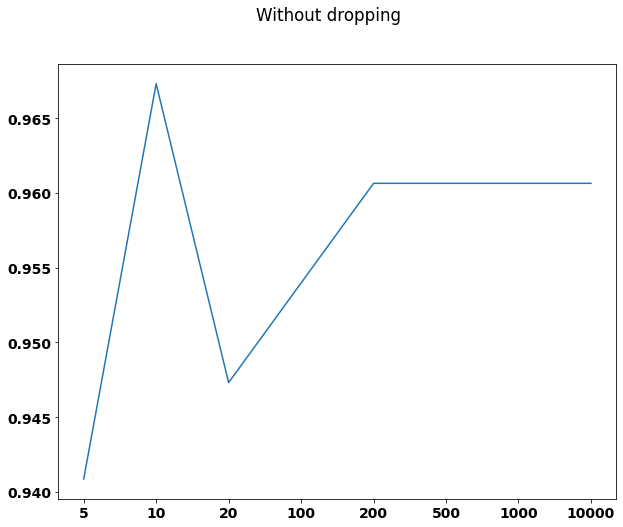

In [113]:
plt.figure(figsize=(10,8))
keys = scores_mean.keys()
values= scores_mean.values()
plt.plot(keys, values)
plt.suptitle("Without dropping");

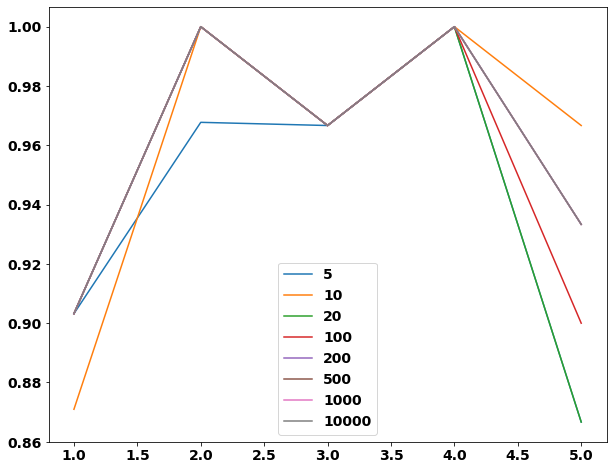

In [99]:
plt.figure(figsize=(10,8))
for key in scores:
    plt.plot(range(1,5+1),scores[key], label=key)
plt.legend();